<center>
    <h1>Time Series Forecasting using CNN</h1>
    <h3>Name: Prerak Shah, Sai Sri Meghana Dharmapuri</h3>
</center>

# 1. Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [2]:
df_stock = pd.read_csv('CSC215_P2_Stock_Price.csv')

In [3]:
df_stock.shape

(4392, 7)

In [4]:
df_stock.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


# Data Cleaning 

# 2. Drop Date and Adj_Close columns

In [5]:
# storing the original dataset in a different dataframe before dropping the columns 
df_stock_new = df_stock
df_stock_new.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [6]:
# dropping the columns Date and Adj_Close
df_stock_new=df_stock_new.drop(['Date', 'Adj_Close'], axis=1)
df_stock_new.head()
#df_stock_new.['y'] = df_stock_new.['Close']

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [7]:
df_stock_new.shape

(4392, 5)

In [8]:
df_stock.shape

(4392, 7)

# 3. Removing null values 

In [9]:
df_stock_new.shape

(4392, 5)

In [10]:
#Calling sum() of the DataFrame returned by isnull() will give a series containing data about count of NaN in each column
df_stock_new.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [11]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']

In [12]:
df_stock_new.head()

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625


# 4. Normalizing the columns 

In [13]:
#Normalizing the training numeric values using zscore
from scipy.stats import zscore
df_stock_new['Open'] = zscore(df_stock_new['Open'])
df_stock_new['High'] = zscore(df_stock_new['High'])
df_stock_new['Low'] = zscore(df_stock_new['Low'])
df_stock_new['Close'] = zscore(df_stock_new['Close'])
df_stock_new['Volume'] = zscore(df_stock_new['Volume'])

In [14]:
x=df_stock_new.as_matrix(columns=['Open','High','Low','Volume','Close'])

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [15]:
x.shape

(4392, 5)

In [16]:
df_stock_new.shape

(4392, 6)

In [17]:
#y=df_stock_new.as_matrix(['y'])

In [18]:
y=df_stock_new['y'].tolist()

In [19]:
y=np.array(y)

In [20]:
y.shape

(4392,)

# 4. Data Transformation

In [21]:
import numpy as np

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [22]:
SEQUENCE_SIZE = 7
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))

Shape of x_seq: (4385, 7, 1, 5)
Shape of y_seq: (4385,)


In [23]:
x_seq_4d = x_seq.reshape(4385,1,7,5)

# 5. Splitting the dataset into test and train data ( 70% train & 30% test )

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_4d,y_seq,test_size=0.30,random_state=0)

In [25]:
X_train.shape

(3069, 1, 7, 5)

In [26]:
len(X_train)

3069

In [27]:
X_test.shape

(1316, 1, 7, 5)

In [28]:
Y_train.shape

(3069,)

In [29]:
Y_test.shape

(1316,)

In [30]:
type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

numpy.ndarray

# <center> <h1>CNN</h1></center>

<h4>Approch 1</h4>
<ul>
    <li>Convolution Layer : 64
    <li>Kernel Size : 3, 3
    <li>Strides: 1, 1
    <li>Dropout : 0.5
    <li>Dense Layers : 64, 1
    <li>Optimizers : adam, sgd
    <li>Activation Functions : relu, sigmoid, tanh
</ul>




Model trained for "adam" optimizer and "relu" activation function : 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 448)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                28736     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
Non

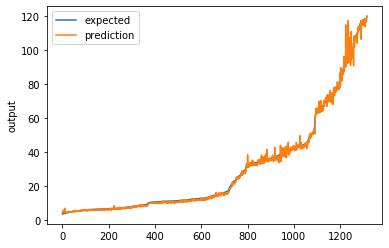




Model trained for "adam" optimizer and "sigmoid" activation function : 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                28736     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 31,745
Trainable params: 31,74

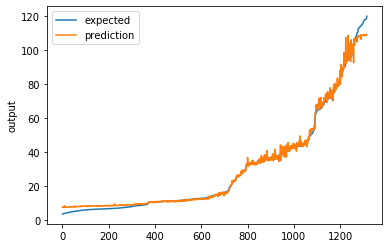




Model trained for "adam" optimizer and "tanh" activation function : 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                28736     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
N

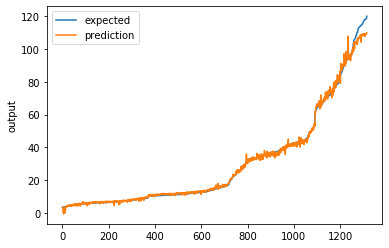




Model trained for "sgd" optimizer and "relu" activation function : 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                28736     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
No

C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 576.0375135799553
Final score (RMSE): 24.000781520191282


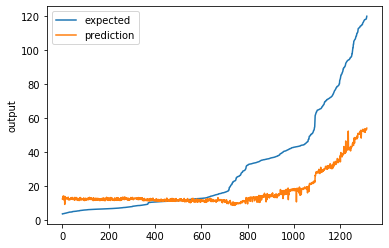




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                28736     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745

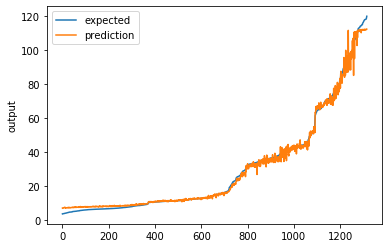




Model trained for "sgd" optimizer and "tanh" activation function : 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 7, 64)          2944      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                28736     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 31,745
Trainable params: 31,745
No

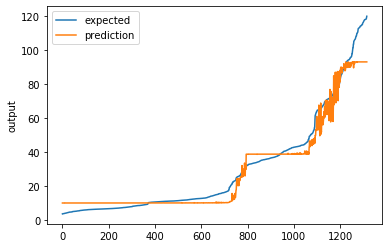

In [31]:
from sklearn import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:
        
        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        
        model = Sequential()
        model.add(Conv2D(64, kernel_size=(3,3), strides=(1, 1), padding='same',activation=act,input_shape=(1,7,5)))
        model.add(MaxPooling2D(pool_size=(1,1), strides=None))
        model.add(Flatten())
        model.add(Dense(64, activation=act))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=opt)
        model.summary()
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)
        
        model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
        model.load_weights('best_weights.hdf5')
        
        pred = model.predict(X_test) 
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,Y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
        print("Final score (RMSE): {}".format(rmse))
        
        chart_regression(pred.flatten(),Y_test,sort=True)

<h4>Approch 2</h4>
<ul>
    <li>Convolution Layer : 32  64 
    <li>Kernel Size : 5,5
    <li>Strides: 1, 1
    <li>Dropout : NONE
    <li>Dense Layers : 64, 1
    <li>Optimizers : adam, sgd
    <li>Activation Functions : relu, sigmoid, tanh
</ul>




Model trained for "adam" optimizer and "relu" activation function : 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 1, 7, 32)          192       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 7, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 7, 64)          2112      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                28736     
_______________________________________________

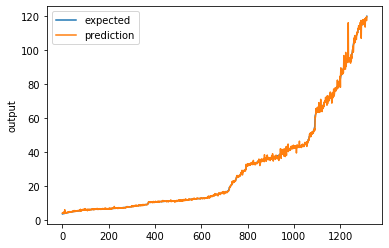




Model trained for "adam" optimizer and "sigmoid" activation function : 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1, 7, 32)          192       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 7, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 7, 64)          2112      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                28736     
____________________________________________

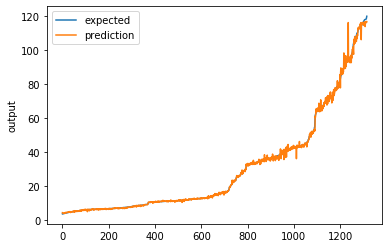




Model trained for "adam" optimizer and "tanh" activation function : 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 7, 32)          192       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 7, 64)          2112      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                28736     
_______________________________________________

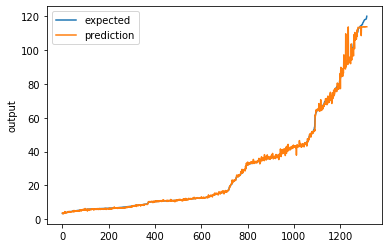




Model trained for "sgd" optimizer and "relu" activation function : 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1, 7, 32)          192       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 7, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 7, 64)          2112      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                28736     
________________________________________________

C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 1s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 17690.91084071725
Final score (RMSE): 133.0071834177284


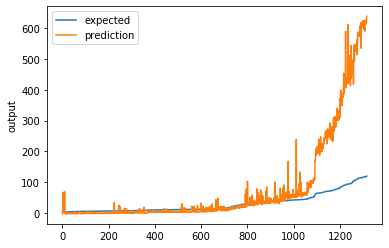




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 1, 7, 32)          192       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 7, 32)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 7, 64)          2112      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                28736     
____________________________________________

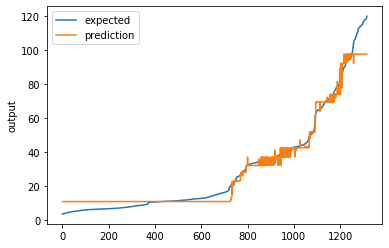




Model trained for "sgd" optimizer and "tanh" activation function : 

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 1, 7, 32)          192       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 7, 32)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 7, 64)          2112      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 7, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                28736     
_______________________________________________

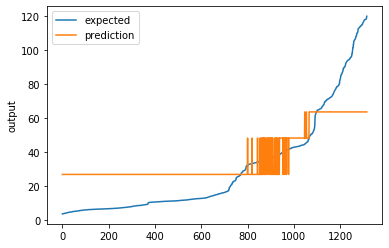

In [32]:
optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:
        
        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(1,1), strides=(1, 1), padding='same',activation=act,input_shape=(1,7,5)))
        model.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
        model.add(Conv2D(64, kernel_size=(1, 1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(1, 1)))
        model.add(Flatten())
        model.add(Dense(64, activation=act))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer=opt)
        model.summary()
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)
        
        model.fit(X_train, Y_train,validation_data=(X_test,Y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
        model.load_weights('best_weights.hdf5')
        
        pred = model.predict(X_test) 
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,Y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
        print("Final score (RMSE): {}".format(rmse))
        chart_regression(pred.flatten(),Y_test,sort=True)